# Classifing hate speech tweets using logistic regression with Tf-Idf and Bag-of-Words vectorizers

## Loading the data set:

In [66]:
import numpy as np
import pandas as pd
import sklearn.model_selection as ms
import sklearn.feature_extraction.text as text
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

In [67]:
from string import punctuation
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [68]:
from datasets import load_dataset

dataset = load_dataset("tweets_hate_speech_detection")

Using custom data configuration default
Reusing dataset tweets_hate_speech_detection (C:\Users\maetu\.cache\huggingface\datasets\tweets_hate_speech_detection\default\0.0.0\c6b6f41e91ac9113e1c032c5ecf7a49b4e1e9dc8699ded3c2d8425c9217568b2)


  0%|          | 0/1 [00:00<?, ?it/s]

In [69]:
df = pd.DataFrame.from_dict(dataset['train'])
df.head()

label                                              tweet
0      0  @user when a father is dysfunctional and is so...
1      0  @user @user thanks for #lyft credit i can't us...
2      0                                bihday your majesty
3      0  #model   i love u take with u all the time in ...
4      0             factsguide: society now    #motivation

# Model Building:

In [70]:
# Definition des Label-Vektors
y = df['label']

## Using TF-IDF Vectorizer

In [71]:
# Definition der Feature-Matrix
tf = text.TfidfVectorizer()

X_vec = tf.fit(df['tweet'])
X = X_vec.transform(df['tweet'])

print(X.shape)

(31962, 41392)


### Split data into train and test data

In [72]:
# Splitting of data into training and test data
from sklearn.model_selection import train_test_split
(X_train, X_test, y_train, y_test) = ms.train_test_split(X, y, test_size=0.2, random_state = 17, stratify=y)

In [73]:
# Testing Stratification
print('There is {} training data, of which {}% is hate speech '.format(y_train.count(), round(y_train.sum()/y_train.count()*100,2)))
print('There is {} test data, of which {}% is hate speech '.format(y_test.count(), round(y_test.sum()/y_test.count()*100,2)))

There is 25569 training data, of which 7.02% is hate speech 
There is 6393 test data, of which 7.01% is hate speech 


### Train Model

In [74]:
def simple_logistic_classify(X_tr, y_tr, X_test, y_test, _C=1.0):
    model = LogisticRegression(C=_C).fit(X_tr, y_tr)
    score = model.score(X_test, y_test)
    print('Test Score:', score)
    return model

In [75]:
model = simple_logistic_classify(X_train, y_train, X_test, y_test)

Test Score: 0.9465039887376818


### Evaluate Performance of the Model using  a Tf-Idf vectorizer

In [83]:
def evaluation(xTest, yTest, vectorizer):
    print('Results for Logistic Regression using a ' + str(vectorizer) + ' vectorizer:')
    print(f'The hit rate with the simple logistic regression is approx. {round(100*model.score(xTest, yTest),2)}%')
    print('Precision: %.3f' % precision_score(yTest, model.predict(xTest)))
    print('Recall: %.3f' % recall_score(yTest, model.predict(xTest)))
    print('Accuracy: %.3f' % accuracy_score(yTest, model.predict(xTest)))
    print('F1 Score: %.3f' % f1_score(yTest, model.predict(xTest)))

In [84]:
evaluation(X_test, y_test, 'Tf-Idf')

Results for Logistic Regression using a Tf-Idf vectorizer:
The hit rate with the simple logistic regression is approx. 94.65%
Precision: 0.942
Recall: 0.252
Accuracy: 0.947
F1 Score: 0.398


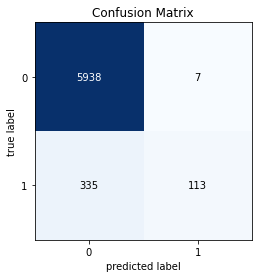

In [86]:
# Confusion-Matrix
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_test, model.predict(X_test))

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.title("Confusion Matrix")
plt.show()

# Using a BoW Vectorizer

In [87]:
bow_converter = CountVectorizer()

Xc = bow_converter.fit_transform(df['tweet'])

print(Xc.shape)

(31962, 41392)


### Split Data

In [88]:
# Splitting of data into training and test data
(Xc_train, Xc_test, yc_train, yc_test) = ms.train_test_split(Xc, y, test_size=.2, random_state = 17)

### Train Model

In [89]:
bow_model = simple_logistic_classify(Xc_train, yc_train, Xc_test, yc_test)

Test Score: 0.9641795714062256


C:\Users\maetu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Evaluate Model Performance based on BOW Vectorizer

In [92]:
evaluation(Xc_test, yc_test, 'BoW')

Results for Logistic Regression using a BoW vectorizer:
The hit rate with the simple logistic regression is approx. 89.32%
Precision: 0.375
Recall: 0.893
Accuracy: 0.893
F1 Score: 0.528


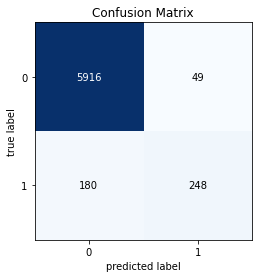

In [93]:
# Confusion-Matrix
cm = confusion_matrix(yc_test, bow_model.predict(Xc_test))

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.title("Confusion Matrix")
plt.show()

# Regression using upsampled data

In [53]:
# Train vectorizer BEFORE upsampling
tf = text.TfidfVectorizer(stop_words='english')
X_tf_vec = tf.fit(df['tweet'])
#X_tf_vec = tf.fit(df['no_user'])

co = text.CountVectorizer(stop_words='english')
X_co_vec = co.fit(df['tweet'])
#X_co_vec = co.fit(df['no_user'])

In [54]:
# Prepare Split data
y = df['label']
X = df['tweet']
#X = df['no_user']

In [55]:
# Split data BEFORE upsampling
(X_train, X_test, y_train, y_test) = ms.train_test_split(X, y, test_size=0.2, random_state = 17, stratify=y)

df_train = pd.concat([y_train,X_train], axis=1)
df_test = pd.concat([y_test,X_test], axis = 1)
df_train.head()

label                                              tweet
30405      0  when everyone's free when you're in exam mode ...
27807      0  #jacksonville   rooster simulation: i want to ...
8660       0  @user just run 10kms for @user @user   #loveis...
19185      0  @user got the prototype for our new usb today!...
10355      0  have a   &amp; #healthy #fathersday. #runnerda...

In [56]:
data_minority = df_train[df_train.label == 1]
data_majority = df_train[df_train.label == 0]

print("length majority", len(data_majority))
print("length minority", len(data_minority))

length majority 23775
length minority 1794


In [57]:
from sklearn.utils import resample
data_minority = resample(data_minority, replace = True, n_samples=23775, random_state=55)

In [58]:
df_train_up = pd.concat([data_majority, data_minority])
df_train_up.label.value_counts()

0    23775
1    23775
Name: label, dtype: int64

In [59]:
# create embeddings

# tfifd
Xt_train = X_tf_vec.transform(df_train_up['tweet'])
Xt_test = X_tf_vec.transform(df_test['tweet'])

# count vectorizer
Xc_train = X_co_vec.transform(df_train_up['tweet'])
Xc_test = X_co_vec.transform(df_test['tweet'])

# labels
y_train = df_train_up['label']
y_test = df_test['label']

print(Xt_train.shape) 

(47550, 41104)


In [60]:
# Testing Stratification
print('There is {} training data, of which {}% is hate speech '.format(df_train_up['label'].count(), round(df_train_up['label'].sum()/df_train_up['label'].count()*100,2)))
print('There is {} test data, of which {}% is hate speech '.format(df_test['label'].count(), round(df_test['label'].sum()/df_test['label'].count()*100,2)))

There is 47550 training data, of which 50.0% is hate speech 
There is 6393 test data, of which 7.01% is hate speech 


## Model Building

In [97]:
''' #TF-IDF
# Multi-variate Bernoulli Naive Bayes
bnb = ms.GridSearchCV(nb.BernoulliNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
bnb.fit(Xt_train, y_train);

# Multinominal Naive Bayes
mnb = ms.GridSearchCV(nb.MultinomialNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
mnb.fit(Xt_train, y_train);

# Count Vectorizer
# Multi-variate Bernoulli Naive Bayes
cbnb = ms.GridSearchCV(nb.BernoulliNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
cbnb.fit(Xc_train, y_train);

# Multinominal Naive Bayes
cmnb = ms.GridSearchCV(nb.MultinomialNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
cmnb.fit(Xc_train, y_train); '''

#Tf-Idf vectorizer
#model = simple_logistic_classify(Xt_train, yc_train, Xt_test, yc_test)

#BoW vectorizer
bow_model = simple_logistic_classify(Xc_train, yc_train, Xc_test, yc_test)

Test Score: 0.9641795714062256


C:\Users\maetu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [98]:
evaluation(Xc_test, yc_test, 'BoW')

Results for Logistic Regression using a BoW vectorizer:
The hit rate with the simple logistic regression is approx. 89.32%
Precision: 0.375
Recall: 0.893
Accuracy: 0.893
F1 Score: 0.528
